### ライブラリの準備

###モジュールのインポート

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
#from tqdm import tqdm
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from collections import deque
from typing import Sequence, Dict, Tuple, Union

import torch
from torch import nn
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import torchvision.datasets as dataset
from torchvision.transforms import v2
import torchvision.transforms as T

from transformers import  CLIPVisionModel, get_linear_schedule_with_warmup

import util
import levenshtein
from nltk import bleu_score
#from cidereval import cider, ciderD

import tiktoken
from previous_chapters import CAPT_AR_PAD_GPTModel, load_weights_into_gpt
from gpt_download import download_and_load_gpt2

2025-08-13 03:17:58.877268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 03:17:58.888706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755022678.902869   27279 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755022678.907702   27279 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755022678.919686   27279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### CaptioningTransformer

In [2]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, clip_dim: int, dim_embedding: int, vocab_size: int, tokenizer, dropout: float = 0.1, endoftext_token_id: int=50256):
        super().__init__()

        #CLIP
        path = "../clip-vit-large-patch14-336"
        self.clip_model = CLIPVisionModel.from_pretrained(pretrained_model_name_or_path = path, output_hidden_states = True)
        
        # Dense Connector
        #self.dc_ln = nn.LayerNorm( clip_dim * 3 )
        self.dc_linear = nn.Linear( clip_dim * 3, dim_embedding )
        self.dropout = nn.Dropout( dropout )        
        self.ln_memory = nn.LayerNorm( dim_embedding )

        # Down Sampling
        self.conv1 = nn.Conv1d( dim_embedding, dim_embedding, 1, 5 )
        self.conv2 = nn.Conv1d( dim_embedding, dim_embedding, 1, 2 )

        # Word Embeidding
        self.emb = nn.Embedding( vocab_size, dim_embedding )
        
        #GPT2 as decoder
        BASE_CONFIG = {
            "vocab_size": 50257,     # Vocabulary size
            "context_length": 1024,  # Context length
            "drop_rate": 0.0,        # Dropout rate
            "qkv_bias": True         # Query-key-value bias
        }
        model_configs = {
            "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
            "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
            "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
            "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
        }

        CHOOSE_MODEL = "gpt2-large (774M)"

        BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

        model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
        settings, params = download_and_load_gpt2(
            model_size=model_size,
            models_dir="gpt2"
        )

        self.decoder = CAPT_AR_PAD_GPTModel(BASE_CONFIG)
        load_weights_into_gpt(self.decoder, params)
        
        # Others
        self.dim_embedding = dim_embedding
        self.tokenizer = tokenizer
        self.endoftext_token_id = endoftext_token_id

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, images: torch.Tensor, captions: torch.Tensor ):

        self.device = images.device

        memory = self.clip_model( images )
        memory = self.dense_connector( memory )
        memory = self.dropout( memory )
        memory = self.ln_memory( memory )

        memory = self.conv1( memory.transpose(1,2) )
        memory = self.conv2( memory ).transpose( 1, 2 )

        def my_index( list0, int0):
            if int0 in list0:
                return list0.index( int0 )
            else:
                return -1
        
        pad_pos = torch.tensor( [], device = self.device, dtype=torch.int )
        for caption in captions:
            pad_pos0 = my_index( caption.tolist(), self.endoftext_token_id ) 
            if pad_pos0 == -1:
                pad_pos = torch.cat( [pad_pos, torch.tensor([len( caption ) + 1]  , device = self.device)], dim = 0 )
            else:
                pad_pos = torch.cat( [pad_pos, torch.tensor([pad_pos0 + 1], device = self.device)], dim = 0 )
            
        emb_caption = self.emb( captions )

        gpt_in = torch.cat( [memory, emb_caption], dim = 1 )
        gpt_in_padding_masks = torch.ones( gpt_in.shape[:2], device = self.device ).bool()
        for n in range( len( gpt_in_padding_masks ) ):
            gpt_in_padding_masks[n,:memory.size(1) + pad_pos[n]] = False
        
        outputs = self.decoder( gpt_in, gpt_in_padding_masks )
        #outputs = self.decoder( inputs_embeds = gpt_in, attention_mask = gpt_in_padding_masks ).logits
        #outputs = self.decoder( inputs_embeds = gpt_in, attention_mask = gpt_in_padding_masks ).last_hidden_state
        #print( "ouputs:", outputs )
        outputs = outputs[:,memory.size(1) - 1:]
        
        return outputs

    def dense_connector(self, memory ):
        tmp1 = torch.tensor([], device = self.device )
        tmp2 = torch.tensor([], device = self.device )
        tmp_full = len( memory.hidden_states )
        tmp_half = tmp_full // 2
        for i in range( 0, tmp_half ):
            tmp1 = torch.cat( [tmp1, memory.hidden_states[i][None]], dim = 0 )
        tmp1 = torch.sum(tmp1, dim=0) / tmp_half
        for i in range( tmp_half, tmp_full ):
            tmp2 = torch.cat( [tmp2, memory.hidden_states[i][None]], dim = 0 )
        tmp2 = torch.sum(tmp2, dim=0 ) / ( tmp_full - tmp_half )
        tmp3 = torch.cat([tmp1, tmp2], dim=-1)
        tmp3 = torch.cat( [ memory.last_hidden_state, tmp3], dim = -1 )
        #tmp3 = sel.dc_ln( tmp3 )
        tmp3 = self.dc_linear( tmp3 )
        return tmp3

In [3]:
class MyDataset(Dataset):
    def __init__(self, file_path: str, img_directory: str, transforms, tokenizer) -> None:
        super().__init__()
        self.img_directory = img_directory
        self.transforms = transforms
        # TODO: fix to original data
        #画像の前処理
        self.img_file = []
        self.tokenss = []
        with open( file_path, "r" ) as f:
            #line = f.readline()
            #i = 0
            #while line:
            for i, line in enumerate( f ):
                if i % 100000 == 0:
                #    #print( line.split("\t")[0])
                #    #print( line.split("\t")[1])
                    print( "i:", i )
                #i += 1
                self.img_file.append(line.split("\t" )[0])
                caption = line.split("\t")[1].replace( "\r\n", "" ).replace( "\n", "").replace( "\r", "" ) + " <|endoftext|>"
                #print( "caption:", caption )
                id_tokens = tokenizer.encode( caption, allowed_special={"<|endoftext|>"})
                id_tokens = torch.tensor( id_tokens, requires_grad = False  )
                #print( "id_tokens:", id_tokens )
                self.tokenss.append( id_tokens )

                #line = f.readline()

    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ):
        tokens = self.tokenss[index]
        img_file = self.img_file[index] + ".jpg"
        img_path = os.path.join( self.img_directory, img_file ) #index番目の画像のパスを取得
        img = Image.open(img_path) #PIL形式で画像を読み込み
        if img.mode != 'RGB':
            img = img.convert("RGB")
        img = self.transforms(img)
        
        return img, tokens

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.tokenss)

In [4]:
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, str]]], pad_index ):
    imgs, tokens = zip(*batch)

    max_length = 0
    for target in tokens:
        if max_length < len( target ):
            max_length = len( target )
    
    targets = []
    lengths = []
    for target in tokens:
        pad_len = max_length - len( target ) 
        #print( "target:", target )
        input2= F.pad( target, (0, pad_len), mode='constant', value = pad_index)
        targets.append( input2 )
        lengths.append( len( target ) )
    
    imgs = torch.stack( imgs, dim = 0 )
    targets = torch.stack( targets, dim = 0 )
    lengths = torch.tensor( lengths )

    #if imgs.dim() != 4:
    #   print( "in collate imgs size:", imgs.size() )
    
    return imgs, targets, lengths

In [13]:
tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = 50257
endoftext_token_id = 50256

caption = "Hello World! <|endoftext|>".lower()
token_ids = tokenizer.encode( caption, allowed_special={"<|endoftext|>"} )
print( token_ids )
#decoded = tokenizer.tokenize( token_ids )
#print( decoded )
decoded = tokenizer.decode( token_ids )
print( decoded )
#print( tokenizer.tokenize( decoded ) )
#individual_decoded_tokens = list(map(tokenizer.decode, token_ids))
individual_decoded_tokens = [tokenizer.decode( [token] ) for token in token_ids ]
print( individual_decoded_tokens )

tmp = tokenizer.decode( [91] )
print( tmp )

[31373, 995, 0, 220, 50256]
hello world! <|endoftext|>
['hello', ' world', '!', ' ', '<|endoftext|>']
|


i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
torch.Size([4, 56])
torch.Size([4, 3, 336, 336])


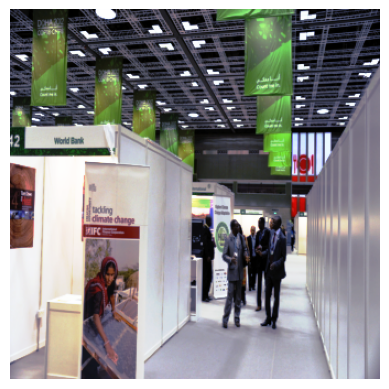

In [6]:
tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = 50257
endoftext_token_id = 50256
collate_func_lambda = lambda x: collate_func(x, endoftext_token_id)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((336, 336)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# 画像のtransformsを定義
#transforms = T.Compose([
#    T.Resize((336, 336)),
#    T.RandomHorizontalFlip(),
#    T.ToTensor(),
#    # ImageNetデータセットの平均と標準偏差
#    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#])


# v7 データセット
train_dataset = MyDataset( file_path="../CLIP_LLM_AR/dataset.txt",
                           img_directory = "/mnt/ssd2/v7/img",
                           #img_directory = "smb://192.168.1.2/img/v7/",
                           transforms=transforms, tokenizer = tokenizer)

# Subset samplerの生成
#val_set, train_set = util.generate_subset(
#    train_dataset, config.val_ratio)
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, 0.1, 0.1 )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, endoftext_token_id )
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=4,
                    num_workers=0,
                    shuffle = False,
                    #sampler=train_sampler,
                    pin_memory = True,
                    collate_fn=collate_func_lambda)
transforms_inv = v2.Compose([
    v2.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954,1/0.26130258,1/0.27577711)),
    v2.ToPILImage()
])


#for n, (imgs, targets, lengths) in enumerate( train_loader ):
#    #print( "imgs size:", imgs.size())
#    if n % 100 == 0:
#        print( "n:", n )
    
imgs, targets, lengths = next(iter(train_loader))

##print( targets )
print( targets.size() )
print( imgs.size() )
##print( imgs[0] )
##img[0].show()
inv_img = transforms_inv( imgs[0] )
plt.imshow( inv_img )
plt.axis('off')
plt.show()

###学習におけるハイパーパラメータやオプションの設定

In [5]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        self.clip_dim = 1024
        self.dim_embedding = 1280   # 埋め込み層の次元
        #self.lr = 5e-5            # 学習率
        #self.lr = 2e-5            # 学習率
        #self.lr = 1e-5            # 学習率
        #self.lr = 2e-6            # 学習率
        #self.lr = 1e-6            # 学習率
        #self.lr = 5e-7            # 学習率
        self.lr = 2e-7            # 学習率
        self.dropout = 0.1
        #self.batch_size = 128       # ミニバッチ数
        #self.batch_size = 8       # ミニバッチ数
        self.batch_size = 6       # ミニバッチ数
        #self.batch_size = 4       # ミニバッチ数
        #self.batch_size = 2       # ミニバッチ数
        #self.num_epochs = 100       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 60       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.num_epochs = 5       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.use_amp = True
        #self.use_amp = False
        #self.use_saved_pth = True
        self.use_saved_pth = False
        self.vocab_size = 50257
        self.endoftext_token_id = 50256

        # パスの設定
        self.img_directory = '/mnt/ssd2/v7/img'
        self.anno_file = '../CLIP_LLM_AR/dataset.txt'
        self.save_directory = './model'

        # 検証に使う学習セット内のデータの割合
        self.test_ratio = 0.1
        self.val_ratio = 0.1
        #self.val_ratio = 0.0004
        #self.test_ratio = 0.0004
        
        # 学習に使うデバイス
        #self.device = 'cuda'
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.device = 'cpu'
        
        # データローダーに使うCPUプロセスの数
        #self.num_workers = 4
        self.num_workers = 0 if self.device == torch.device('cpu') else 8
        #self.num_workers = 0 if self.device == torch.device('cpu') else 6
        #self.num_workers = 0
        
        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

In [8]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = 50257
endoftext_token_id = 50256
model = CaptioningTransformer(clip_dim = 1024, dim_embedding=1280, vocab_size=vocab_size,tokenizer=tokenizer, \
                             dropout = 0.1, endoftext_token_id = endoftext_token_id ).to(device)
images = torch.randn( ( 2, 3, 336,336 ), device = device )
captions = torch.randint( 0, vocab_size, size=( 2, 50  ), device = device )
outputs = model( images, captions[:,:-1] )

print( outputs.size() )

File already exists and is up-to-date: gpt2/774M/checkpoint
File already exists and is up-to-date: gpt2/774M/encoder.json
File already exists and is up-to-date: gpt2/774M/hparams.json
File already exists and is up-to-date: gpt2/774M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/774M/model.ckpt.index
File already exists and is up-to-date: gpt2/774M/model.ckpt.meta
File already exists and is up-to-date: gpt2/774M/vocab.bpe
torch.Size([2, 50, 50257])


### 学習を行う

In [6]:
config = ConfigTrain()

print( "use_amp:", config.use_amp )

tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = config.vocab_size
endoftext_token_id = config.endoftext_token_id

# モデル出力用のディレクトリを作成
os.makedirs(config.save_directory, exist_ok=True)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((336, 336)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# v7 データセット
train_dataset = MyDataset( file_path=config.anno_file,
                           img_directory = config.img_directory,
                           transforms=transforms,tokenizer=tokenizer)

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, config.test_ratio, config.val_ratio )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, endoftext_token_id)
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=train_sampler,
                    collate_fn=collate_func_lambda)

val_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=val_set,
                    collate_fn=collate_func_lambda)

test_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    #batch_size=config.batch_size,
                    batch_size=1,
                    num_workers=config.num_workers,
                    sampler=test_set,
                    collate_fn=collate_func_lambda)


print( "device:", config.device )
print( "学習セット数:",len( train_loader ) )
print( "評価セット数:",len( val_loader ))
print( "テストセット数:",len( test_loader ))
    
# モデルの定義
model = CaptioningTransformer( config.clip_dim, config.dim_embedding, config.vocab_size, tokenizer,\
                              config.dropout, config.endoftext_token_id )
model = model.to(config.device) 

# 損失関数の定義
criterion = nn.CrossEntropyLoss( reduction = 'mean' )

# 最適化手法の定義
optimizer = torch.optim.AdamW( model.parameters() , lr=config.lr)

# 全ステップ数
num_global_steps = len( train_loader ) * config.num_epochs
print( "num_global_steps:", num_global_steps )
num_warmup_steps = num_global_steps * 0.1
print( "num_warmup_steps:", num_warmup_steps )
#スケジューラーの定義
scheduler = get_linear_schedule_with_warmup( optimizer, num_warmup_steps, num_global_steps )    

PATH = f'{config.save_directory}/model_ar_gpt2_v7_curr.pth'
print( "use_saved_pth:", config.use_saved_pth )
print( "exist saved_pth:", os.path.isfile(PATH) ) 
if config.use_saved_pth and os.path.isfile(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    ##device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ## optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
    #for state in optimizer.state.values():
        #for k, v in state.items():
            #if isinstance(v, torch.Tensor):
                #state[k] = v.to(device)
    begin_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    global_step = checkpoint['global_step']
else:
    begin_epoch = 0
    global_step = 0

print( "begin_epoch:", begin_epoch )
print( "global_step:", global_step )
    
len_tr_loader = len( train_loader )
train_param = len_tr_loader // 3
len_val_loader = len( val_loader )
#train_param = len_val_loader // 3
val_param = len_val_loader // 3
print( "train_param:", train_param )
print( "val_param:", val_param )

# 学習経過の書き込み
now = datetime.datetime.now()
train_loss_file = '{}/MyOriginal_train_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(train_loss_file, 'a') as f:
    print(f'{len_tr_loader}', file=f)
print( "train_loss_file:", train_loss_file )
val_loss_file = '{}/MyOriginal_val_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(val_loss_file, 'a') as f:
    print(f'{len_val_loader}', file=f) 
norm_file = '{}/norm_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

# 学習
val_loss_best = float('inf')

fn = bleu_score.SmoothingFunction().method7

# AMP用のスケーラー
scaler = GradScaler(enabled=config.use_amp)

for epoch in range(begin_epoch, config.num_epochs):
    with tqdm(train_loader) as pbar:
    #with tqdm(val_loader) as pbar:
        pbar.set_description(f'[エポック {epoch + 1}]')

        # 学習モードに設定
        model.train()

        train_losses = deque()
        train_errors = deque()
        train_bleus = deque()
        #train_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):
            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            #caption_lengths = torch.tensor(caption_lengths).to(config.device)
                
            optimizer.zero_grad()

            with autocast(str(config.device),enabled=config.use_amp):
                outputs = model( imgs, captions[:,:-1] )
                # 損失の計算
                loss = criterion(outputs.transpose(1,2), captions)

            hypo_ids = torch.argmax( outputs, dim = 2 )
                
            # 誤差逆伝播
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            clip_grad_threshold = 5.0
            torch.nn.utils.clip_grad_norm_(\
                    model.parameters(),
                    clip_grad_threshold)
            # オプティマイザにより，パラメータを更新する
            scaler.step(optimizer)
            scaler.update()            
            
            scheduler.step()

            #for name, param in model.named_parameters():
            #    print( name )
            # 勾配消失が起こっていないか監視
            norm0 = torch.sqrt( torch.norm( model.clip_model.vision_model.encoder.layers[0].self_attn.q_proj.weight.grad, p = 2 ) ).item()
            norm1 = torch.sqrt( torch.norm( model.decoder.trf_blocks[35].att.W_query.weight.grad, p = 2 ) ).item()
            norm_mean = torch.mean( torch.stack ([ torch.sqrt( torch.norm( param.grad, p = 2 ) ) \
                                                  for param in model.parameters() if param.grad is not None ] ) ).item()
            with open(norm_file, 'a') as f:
                print( "epcoch:", epoch, ", step:", global_step, ", norm0:", norm0, ", norm1:", norm1, ", norm_mean:", norm_mean, file=f  )
                f.flush()
            global_step += 1

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for n3, (hypo_id, caption) in enumerate( zip( hypo_ids, captions )):
                #print( "n_batch:", n_batch, " n3:", n3, "caption:", caption )
                hypo = tokenizer.decode( [token_id for token_id in hypo_id.tolist() if token_id != 50256 ] )
                reference = tokenizer.decode( [token_id for token_id in caption.tolist() if token_id != 50256 ] )
                hypo_tokens = [tokenizer.decode( [token_id] ) for token_id in hypo_id if token_id != 50256 ]
                ref_tokens = [tokenizer.decode( [token_id] ) for token_id in caption if token_id != 50256 ]
                #print( "hypo_tokens:", hypo_tokens )
                #print( "ref_tokens:", ref_tokens )
                
                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens,ref_tokens)
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                
                if n < 1 and n_batch == len( train_loader ) - 1 :
                #if n < 1 and n_batch == len( val_loader ) - 1 :
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                if n < 1 and n_batch % train_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
            
            avg_error = total_error / total_token_length * 100
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2
            
            # 学習時の損失をログに書き込み
            train_losses.append(loss.item())
            train_errors.append( avg_error )
            train_bleus.append( avg_bleu )
            #train_ciders.append( avg_cider )
            if len(train_losses) > config.moving_avg:
                train_losses.popleft()
                train_errors.popleft()
                train_bleus.popleft()
                #train_ciders.popleft()
            mean_loss = torch.Tensor(train_losses).mean().item()
            mean_error = torch.Tensor(train_errors).mean().item()
            mean_bleu = torch.Tensor(train_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'WER': mean_error,
                'BLEU': mean_bleu,
                #'CIDER': torch.Tensor(train_ciders).mean().item()
            })
            with open(train_loss_file, 'a') as f:
                #print(f'{epoch}, {loss.item()},  {avg_error}, {avg_bleu}, {avg_cider}', file=f)
                print(f'{epoch}, {mean_loss}, {mean_error}, {mean_bleu}', file=f)
            print_flag = 1
            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                if print_flag == 1:
                    print( "lr:", optimizer.param_groups[0]["lr"] )
                    print_flag = 0
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print(f'Train epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Train epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # 学習率を表示
    print(f'学習率: {optimizer.param_groups[0]['lr']}')
    train_loss = np.mean(train_losses)
    train_error = np.mean(train_errors )
    train_bleu = np.mean(train_bleus )
    #train_cider = np.mean(train_ciders )
    print(f'Train loss: {train_loss}')
    print(f'Train WER: {train_error}')        
    print(f'Train BLEU: {train_bleu}')
    #print(f'Train CIDER: {train_cider}')

    # 検証
    with tqdm(val_loader) as pbar:
        pbar.set_description(f'[検証]')

        # 評価モード
        model.eval()

        val_losses = deque()
        val_errors = deque()
        val_bleus = deque()
        #val_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):

            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            #caption_lengths = torch.tensor( caption_lengths ).to(config.device)
                
            with torch.no_grad():
                outputs = model( imgs, captions[:,:-1] )
                hypo_ids = torch.argmax( outputs, dim = 2 )

                # 損失の計算
                loss = criterion( outputs.transpose(1,2), captions )
                
            val_losses.append(loss.item())

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for (hypo_id, caption) in zip( hypo_ids, captions ):
                hypo = tokenizer.decode( [token_id for token_id in hypo_id.tolist() if token_id != 50256 ] )
                reference = tokenizer.decode( [token_id for token_id in caption.tolist() if token_id != 50256 ] )
                hypo_tokens = [tokenizer.decode( [token_id] ) for token_id in hypo_id if token_id != 50256 ]
                ref_tokens = [tokenizer.decode( [token_id] ) for token_id in caption if token_id != 50256 ]

                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens, ref_tokens)
                    
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                #print("hypo:", ' '.join(hypo))

                if n < 1 and n_batch == len( val_loader ) - 1:
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                        
                if n < 1 and n_batch % val_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
                
            avg_error = total_error / total_token_length * 100                    
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2

            # 学習時の損失をログに書き込み
            val_losses.append(loss.item())
            val_errors.append( avg_error )
            val_bleus.append( avg_bleu )
            if len(val_losses) > config.moving_avg:
                val_losses.popleft()
                val_errors.popleft()
                val_bleus.popleft()
            mean_loss = torch.Tensor(val_losses).mean().item()
            mean_error = torch.Tensor(val_errors).mean().item()
            mean_bleu = torch.Tensor(val_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'WER': mean_error,
                'BLEU': mean_bleu,
            })
            # Validation Lossをログに書き込み
            with open(val_loss_file, 'a') as f:
                print(f'{epoch}, {mean_loss},  {mean_error}, {mean_bleu}', file=f)

            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # Loss 表示
    val_loss = np.mean(val_losses)
    val_error = np.mean( val_errors )
    val_bleu = np.mean( val_bleus )
    #val_cider = np.mean( val_ciders )
    print(f'Validation loss: {val_loss}')
    print(f'Validation WER: {val_error}')
    print(f'Validation BLEU: {val_bleu}')
    #print(f'Validation CIDER: {val_cider}')

    # より良い検証結果が得られた場合、モデルを保存
    if val_loss < val_loss_best:
        val_loss_best = val_loss

        # モデルを保存
        torch.save({'epoch': epoch,
                    'global_step': global_step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,},
            f'{config.save_directory}/model_ar_gpt2_v7_best.pth')
            
    # モデルを保存
    torch.save({'epoch': epoch,
                'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,},
        f'{config.save_directory}/model_ar_gpt2_v7_curr.pth')
        
# モデルを保存
torch.save({'epoch': epoch,
    'global_step': global_step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss,},
    f'{config.save_directory}/model_ar_gpt2_v7_final.pth')

use_amp: True
i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
device: cuda:0
学習セット数: 67660
評価セット数: 8458
テストセット数: 50744
File already exists and is up-to-date: gpt2/774M/checkpoint
File already exists and is up-to-date: gpt2/774M/encoder.json
File already exists and is up-to-date: gpt2/774M/hparams.json
File already exists and is up-to-date: gpt2/774M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/774M/model.ckpt.index
File already exists and is up-to-date: gpt2/774M/model.ckpt.meta
File already exists and is up-to-date: gpt2/774M/vocab.bpe
num_global_steps: 338300
num_warmup_steps: 33830.0
use_saved_pth: False
exist saved_pth: True
begin_epoch: 0
global_step: 0
train_param: 22553
val_param: 2819
train_loss_file: ./model/MyOriginal_train_loss_20250813_031851.csv


  0%|          | 0/67660 [00:00<?, ?it/s]

/home/uchiyats/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr: 5.911912503694945e-12
Train epoch = 0, loss = 7.431875228881836, WER = 222.5108184814453, BLEU = 6.196057319641113
refe: As we can see in the image there are trees, sky, water and a boy sitting over here. 
hypo: 's,ess territory sectorers Code area of Sage Sness Sly of Ss, Sile I~ S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S Srial S S S S S S S S S S S
lr: 1.333372746083358e-07
Train epoch = 0, loss = 1.527249813079834, WER = 54.732933044433594, BLEU = 61.85848617553711
refe: In the center of the image we can see a toy house. 
hypo: In this image of the image there can see a table,. In
lr: 1.925923736328702e-07
Train epoch = 0, loss = 1.2568442821502686, WER = 48.709075927734375, BLEU = 66.43811798095703
refe: In the center of the image, we can see a fence around the statue and in the background, there are trees and we can see a light and a building. At the bottom, there is road and on the right, there is a vehicle. At the top,

  0%|          | 0/8458 [00:00<?, ?it/s]

Val epoch = 0, loss = 1.0684196949005127, WER = 46.96356201171875, BLEU = 69.08673858642578
refe: In this image I can see few trees which are green in color, few flowers which are red in color and in the background I can see a person standing, the road, few vehicles, few buildings, few trees and the sky. 
hypo: In this image I can see the trees, are in in green. few trees, are in in color and white color background I can see few building standing and few sky and few trees, few trees, few trees and the sky. 
Val epoch = 0, loss = 1.180884838104248, WER = 46.776344299316406, BLEU = 67.69834899902344
refe: In this image in the foreground there is one sculpture and in the background there is a building, and at the top there is sky. 
hypo: In this image we the center there is a person. in the background there is a building. there the the top there is sky. 
Val epoch = 0, loss = 1.1843304634094238, WER = 46.7358512878418, BLEU = 68.45578002929688
refe: In this image there are pillars and sla

  0%|          | 0/67660 [00:00<?, ?it/s]

lr: 1.777771208986107e-07
Train epoch = 1, loss = 1.1136668920516968, WER = 46.4163818359375, BLEU = 71.36420440673828
refe: In this image I can see the group of people with different color dresses. I can see few people are siting in-front of the table. On the table I can see the brown color boxes with food and bottles. I can also see few people are standing. In the background there are some kitchen utensils and to the side there are the glass windows. There is a light in the top. 
hypo: In this image I can see a group of people are different color dresses. I can see the people are sitting and.-front of them table. I the table I can see few glasses color cloth, the items glasses. In can also see the other are sitting. In the background I is few lights andensins and I the wall of is few wall windows.  are a wall and the top of 
lr: 1.6296252504351825e-07
Train epoch = 1, loss = 1.1385445594787598, WER = 45.10883712768555, BLEU = 70.5486068725586
refe: This image is taken indoors. At the

  0%|          | 0/8458 [00:00<?, ?it/s]

Val epoch = 1, loss = 0.9678560495376587, WER = 42.91497802734375, BLEU = 73.7388687133789
refe: In this image I can see few trees which are green in color, few flowers which are red in color and in the background I can see a person standing, the road, few vehicles, few buildings, few trees and the sky. 
hypo: In this image we can see few buildings, is green in color and few people, are in in color, white color background I can see few building standing and few sky, few trees, few trees and few trees and the sky. 
Val epoch = 1, loss = 1.0639950037002563, WER = 43.34772491455078, BLEU = 70.85985565185547
refe: In this image in the foreground there is one sculpture and in the background there is a building, and at the top there is sky. 
hypo: In this image we the center there is a statue and in the background there is a building and and the the top there is sky. 
Val epoch = 1, loss = 1.0676590204238892, WER = 43.23604965209961, BLEU = 71.76437377929688
refe: In this image there are pil

  0%|          | 0/67660 [00:00<?, ?it/s]

lr: 1.3333267645416626e-07
Train epoch = 2, loss = 1.0809532403945923, WER = 37.82383346557617, BLEU = 77.62749481201172
refe: In this image I can see a man standing near the mike. In the background, I can see the window. 
hypo: In this image we can see a man is and the wallike. In the background I I can see a wall and 
lr: 1.185180805990738e-07
Train epoch = 2, loss = 1.054117202758789, WER = 43.416141510009766, BLEU = 70.63924407958984
refe: In this image few people are playing some floor game. They are holding stick. In the background there are many chairs and tables. 
hypo: In this image we people are standing a of. and  are wearing some.  the background there are few people. a. 
lr: 1.0370348474398134e-07
Train epoch = 2, loss = 1.0420411825180054, WER = 43.147884368896484, BLEU = 71.22525024414062
refe: In this picture there is a small boy wearing blue t- shirt, grey pant and playing the baseball game. Behind there is a another sitting on the ground wearing black helmet and tryin

  0%|          | 0/8458 [00:00<?, ?it/s]

Val epoch = 2, loss = 0.9047383069992065, WER = 41.29554748535156, BLEU = 74.50997924804688
refe: In this image I can see few trees which are green in color, few flowers which are red in color and in the background I can see a person standing, the road, few vehicles, few buildings, few trees and the sky. 
hypo: In this image we can see few buildings, are in in color and few buildings, are green in color and white the background I can see few building standing and few sky and few trees, few trees and few trees and the sky. 
Val epoch = 2, loss = 1.0180797576904297, WER = 42.2955207824707, BLEU = 71.91813659667969
refe: In this image in the foreground there is one sculpture and in the background there is a building, and at the top there is sky. 
hypo: In this image we the center there is a statue and in the background there is a building. and the the top there is sky. 
Val epoch = 2, loss = 1.0226682424545288, WER = 42.03876876831055, BLEU = 72.7084732055664
refe: In this image there are

  0%|          | 0/67660 [00:00<?, ?it/s]

lr: 8.888823200972181e-08
Train epoch = 3, loss = 1.1389967203140259, WER = 35.52631759643555, BLEU = 73.7499771118164
refe: In this picture there is a boy standing and holding the box and there are vegetables in the box. At the bottom there is grass. 
hypo: In this image we is a boy who in holding a food in there is fruits in the bowl. At the bottom there is a. 
lr: 7.407363615462935e-08
Train epoch = 3, loss = 0.9930953979492188, WER = 42.05738830566406, BLEU = 71.84705352783203
refe: In this picture we can see two woman, the right side woman is holding left side woman's leg, in front of them we can see a bottle, bag on the box. 
hypo: In this image there can see a women sitting one woman side woman is sitting a side and, hand, she the of her we can see a table, bottle, the table, 
lr: 5.92590402995369e-08
Train epoch = 3, loss = 0.9831572771072388, WER = 41.79103088378906, BLEU = 72.61843872070312
refe: In this image on the left side there is water. On the right side there are stone

  0%|          | 0/8458 [00:00<?, ?it/s]

Val epoch = 3, loss = 0.88393634557724, WER = 40.080970764160156, BLEU = 75.76054382324219
refe: In this image I can see few trees which are green in color, few flowers which are red in color and in the background I can see a person standing, the road, few vehicles, few buildings, few trees and the sky. 
hypo: In this image we can see few plants, are in in color and few plants, are green in color and few the background I can see few building walking and few sky, few trees, few trees and few trees and the sky. 
Val epoch = 3, loss = 0.9947270154953003, WER = 41.676055908203125, BLEU = 72.68531799316406
refe: In this image in the foreground there is one sculpture and in the background there is a building, and at the top there is sky. 
hypo: In this image we the center there is a statue and in the background there is a building. and at the top there is sky. 
Val epoch = 3, loss = 0.9990383982658386, WER = 41.2953987121582, BLEU = 73.27101135253906
refe: In this image there are pillars and

  0%|          | 0/67660 [00:00<?, ?it/s]

lr: 4.444378756527736e-08
Train epoch = 4, loss = 1.1076537370681763, WER = 46.02510452270508, BLEU = 73.67835235595703
refe: In this image we can see a table, on the table there are bowls with some food item and spoon in it, there is a glass with water and lemon and few objects on the table, there is a tap and person hand, in the background there is a stove and a bowl on the stove. 
hypo: In this image we can see a table, on the table there are some, food food items, some, it, we is a bowl, food, a, a other on it table. there are a bowl, a is. and the background there is a wall, a wall. the wall. 
lr: 2.962919171018491e-08
Train epoch = 4, loss = 0.9724301099777222, WER = 41.45265579223633, BLEU = 72.90159606933594
refe: In this image in the center there is a shelter and under the shelter there is a cart. In the front there's grass on the ground. In the background there are leaves visible. 
hypo: In this image we the center there is a house, there the house there is a shed and In the 

  0%|          | 0/8458 [00:00<?, ?it/s]

Val epoch = 4, loss = 0.8795095086097717, WER = 38.866397857666016, BLEU = 76.92594909667969
refe: In this image I can see few trees which are green in color, few flowers which are red in color and in the background I can see a person standing, the road, few vehicles, few buildings, few trees and the sky. 
hypo: In this image we can see few trees, are green in color and few flowers, are green in color and few the background I can see few building standing and few sky and few trees, few trees and few trees and the sky. 
Val epoch = 4, loss = 0.986872136592865, WER = 41.407405853271484, BLEU = 72.72453308105469
refe: In this image in the foreground there is one sculpture and in the background there is a building, and at the top there is sky. 
hypo: In this image we the center there is a statue and in the background there is a building and and at the top there is sky. 
Val epoch = 4, loss = 0.9912285208702087, WER = 41.3730583190918, BLEU = 73.08216857910156
refe: In this image there are 

### 推論関数の定義

In [5]:
def inference( imgs, length_max, temperature=0.0, top_k=None ):
    # batch_size = 1 で実行してください。
        
    device = imgs.device

    with torch.no_grad():
        memory = model.clip_model( imgs )
        memory = model.dense_connector( memory )
        memory = model.dropout( memory )
        memory = model.ln_memory( memory )

        memory = model.conv1( memory.transpose(1,2) )
        memory = model.conv2( memory ).transpose( 1, 2 )

        captions = torch.tensor( [[]], device = device, dtype = torch.long )
        
        for i in range( length_max ):
            if i == 0:
                gpt_in_padding_masks = torch.zeros( memory.shape[:2], device = device ).bool()
                logits = model.decoder( inputs_embeds = memory, attention_mask = gpt_in_padding_masks ).logits
            else:
                emb_caption = model.emb( captions )
                gpt_in = torch.cat( [memory, emb_caption], dim = 1 )
                gpt_in_padding_masks = torch.zeros( gpt_in.shape[:2], device = device ).bool()
                logits = model.decoder( inputs_embeds = gpt_in, attention_mask = gpt_in_padding_masks ).logits
            logits = logits[:,-1]
            
            # New: Filter logits with top_k sampling
            if top_k is not None:
                # Keep only top_k values
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)            

            # New: Apply temperature scaling
            if temperature > 0.0:
                logits = logits / temperature

                # Apply softmax to get probabilities
                probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

                # Sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

            # Otherwise same as before: get idx of the vocab entry with the highest logits value
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

            captions = torch.cat( [captions, idx_next], dim = 1 )
            
            #word = torch.argmax( last_outputs, dim = 1 )
            #captions = torch.cat( [captions, word[None]], dim = 1 )
        
    return captions

### テスト

  0%|          | 0/11828 [00:00<?, ?it/s]

avg_erro: 417.7777777777778
test number = 0, WER = 417.7777777777778, BLEU = 11.696702535294362
refe: A dog chewing on a stick on a hardwood floor.
hypo: ily forestwingi football football football football footballlingiumestlyiana in news ofs theandstorys Sp ice the,lyishlylyishes:storyfordailedadingive icetaleivenled avoidancecticitheroundaltoundongadowangeredangered


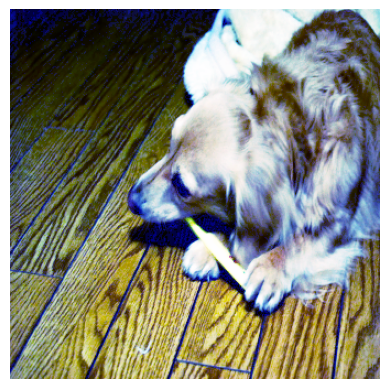

KeyboardInterrupt: 

In [6]:
#test_pr_coef = len( test_loader ) // 20
test_pr_coef = 10

transforms_inv = v2.Compose([
    v2.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954,1/0.26130258,1/0.27577711)),
    v2.ToPILImage()
])

# 検証
with tqdm(test_loader) as pbar:
    pbar.set_description(f'[テスト]')

    # 評価モード
    model.eval()

    test_errors = deque()
    test_bleus = deque()
    total_error = 0
    total_token_length = 0
    total_bleu = 0
    n_batch = 0
    n2 = 0
    length_max = 50
    for k, (imgs, captions, caption_lengths) in enumerate( pbar ):
        if k > 200:
            break
        # ミニバッチを設定
        imgs = imgs.to(config.device)
        captions = captions.to(config.device)
        #caption_lengths = torch.tensor( caption_lengths ).to(config.device)
        
        with torch.no_grad():
            outputs = inference(imgs, length_max )
            hypo_ids = outputs

        n = 0
        hypo_sentence = []
        ref_sentence = []
        ref_imgs = []
        for (hypo_id, caption, img ) in zip( hypo_ids, captions, imgs ):
            hypo = tokenizer.decode( [token_id for token_id in hypo_id.tolist() if token_id != 50256 ] )
            reference = tokenizer.decode( [token_id for token_id in caption.tolist() if token_id != 50256 ] )
            
            # 認識誤りを計算
            (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo,reference)
            
            # 誤り文字数を累積する
            total_error += error
            # 文字の総数を累積する
            total_token_length += ref_length

            bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
        
            total_bleu += bleu
            
            if n < 1 and n_batch % test_pr_coef == 0:
                hypo_sentence.append( hypo )
                ref_sentence.append( reference )
                ref_imgs.append( img )
                   
            n += 1
            n2 += 1
                
        n_batch += 1
        avg_error = total_error / total_token_length * 100
        print( "avg_erro:", avg_error )
        avg_bleu = total_bleu / n2 * 100
                
        test_errors.append(avg_error)
        test_bleus.append(avg_bleu)
                
        if len(test_errors) > config.moving_avg:
            test_errors.popleft()
            test_bleus.popleft()
        pbar.set_postfix({
            #'loss': torch.Tensor(test_losses).mean().item(),
            'WER': torch.Tensor(test_errors).mean().item(),
            'BLEU': torch.Tensor(test_bleus).mean().item()
        })                
                
                    
        for ( hypo_se, ref_se, img ) in zip( hypo_sentence, ref_sentence, ref_imgs ):
            print(f'test number = {k}, WER = {avg_error}, BLEU = {avg_bleu}')
            print( "refe:", ref_se )
            print( "hypo:", hypo_se )
            inv_img = transforms_inv( img )
            plt.imshow( inv_img )
            plt.axis('off')
            plt.show()


# 表示
test_error = np.mean( test_errors )
test_bleu = np.mean( test_bleus )
print(f'test WER: {test_error}')
print(f'test BLEU: {test_bleu}')

In [51]:
reference="A motorbike is parked on a gravel road beside a small river and green woods."
hypo="A motorcycle parked on a dirt road next to a forest.bras."

(error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo,reference)

print( error, substitute, delete, insert, ref_length )
print( error / ref_length * 100 )

42 23 19 0 76
55.26315789473685
